## 0.  Import Dependencies

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. Load Dataset

Link Dataset: [Link Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

### Import Dataset

In [16]:
df = pd.read_csv('dataset/IMDB/IMDB Dataset.csv', sep=',', encoding='utf-8')
# df = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/dataset/IMDB/IMDB Dataset.csv', sep=',', encoding='utf-8')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Check Missing Values

In [17]:
# check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

### Check Data Distribution

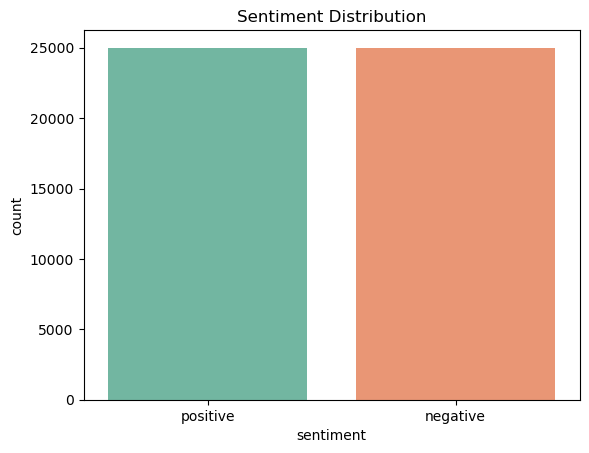

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [18]:
# Check Sentiment Distribution
sns.countplot(x='sentiment', data=df, palette='Set2', hue='sentiment', legend=False)
plt.title('Sentiment Distribution')
plt.show()

print(df['sentiment'].value_counts())

## 2. Cleaning & Preporcess the Data

### Cleaning Data

In [19]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load & Convert contractions dictionary to a more usable format
contraction_df = pd.read_csv('dataset/IMDB/contractions.csv')
# contraction_df = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/dataset/IMDB/contractions.csv')
contractions_map = dict(zip(contraction_df['Contraction'].str.lower(), contraction_df['Meaning'].str.lower()))

In [20]:
# Define a function for text cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis
    # Remove non-alphanumeric characters (keeping whitespace and commas for contraction replacement)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Replace contractions
    text_split = text.split()
    text_split = [contractions_map.get(word, word) for word in text_split]
    text = ' '.join(text_split)

    # Remove punctuation
    text = re.sub(r'[\.,!?;]', '', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])

    return text

# Apply the cleaning function to the review column
df['processed_review'] = df['review'].apply(clean_text)

In [21]:
# Mapping 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [22]:
list(df['processed_review'][:5])

['one reviewer mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bi

In [23]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


### OPTIONAL (TRIM DATA TO 20k) **NOT USED**

In [ ]:
df_trim = df.copy()

# Desired number of samples per class
samples_per_class = 10000

# Count the number of samples for each class
positive_count = (df_trim['sentiment'] == 1).sum()
negative_count = (df_trim['sentiment'] == 0).sum()

print("Number of positive samples:", positive_count)
print("Number of negative samples:", negative_count)

# Sample from each class if there are enough samples
if positive_count >= samples_per_class and negative_count >= samples_per_class:
    trimmed_positive = df_trim[df_trim['sentiment'] == 1].sample(samples_per_class, random_state=42)
    trimmed_negative = df_trim[df_trim['sentiment'] == 0].sample(samples_per_class, random_state=42)

    # Concatenate the two subsets
    df_lemmatization_trim = pd.concat([trimmed_positive, trimmed_negative])

    # Shuffle the dataset to mix positive and negative reviews
    df_lemmatization_trim = df_lemmatization_trim.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the trimmed dataset if needed
    # df_lemmatization_trim.to_csv('Trimmed_IMDB_Dataset.csv', index=False)

    print("Trimmed distribution:\n", df_trim['sentiment'].value_counts())
else:
    print("Not enough samples for each class to perform sampling.")


Number of positive samples: 25000
Number of negative samples: 25000
Trimmed distribution:
 sentiment
1    25000
0    25000
Name: count, dtype: int64


## 3. Some Visulization & Statistical Analysis


### Bar Plot 20 Most Common Words

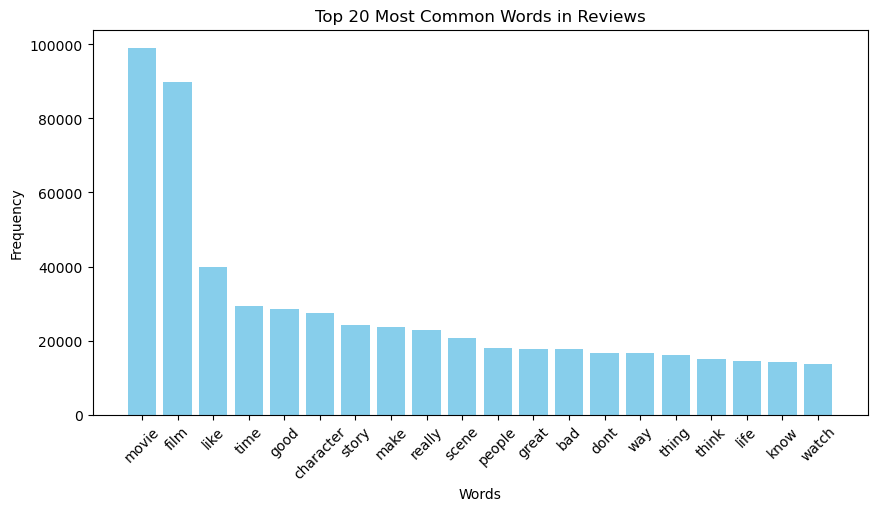

In [ ]:
# Create a CountVectorizer to count word frequencies, limiting to the top 20 words
vectorizer = CountVectorizer(stop_words='english', max_features=20)

# Fit and transform the data
word_counts = vectorizer.fit_transform(df['processed_review'])

# Sum up the counts of each vocabulary word
sum_words = word_counts.sum(axis=0)

# Connecting words with their counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Prepare data for plotting
words, counts = zip(*words_freq)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=45)
plt.show()


### Word Cloud of Most common words in Positive and Negative Review

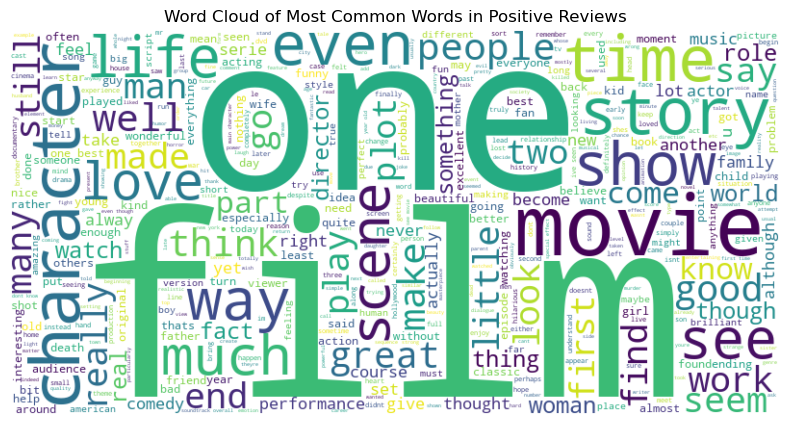

In [ ]:
# Generate Word cloud for positive reviews
positive_reviews = df[df['sentiment'] == 1]
positive_text = list(positive_reviews['processed_review'])
positive_wordcloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white').generate(' '.join(positive_text))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Positive Reviews')
plt.show()

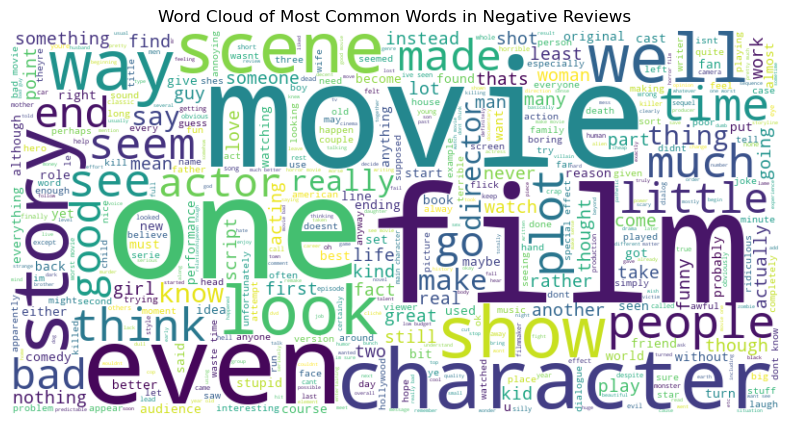

In [ ]:
# Generate Word cloud for negative reviews
negative_reviews = df[df['sentiment'] == 0]
negative_text = list(negative_reviews['processed_review'])
negative_wordcloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white').generate(' '.join(negative_text))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Negative Reviews')
plt.show()

## Model

In [24]:
# Prepare feature matrix X and target vector y
X = df['processed_review']
y = df['sentiment']

In [25]:
# WORD2VEC
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences = [row.split() for row in df['processed_review']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1)

# Save the model for later use
# word2vec_model.save("/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/word2vec_imdb.model")
word2vec_model.save("model/word2vec_imdb.model")

In [14]:
# TF-IDF
# Vectorization of the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(X)

# WORD2VEC
# Convert word vectors to document vectors
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

X_word2vec = np.array([
    average_word_vectors(words, word2vec_model, word2vec_model.wv.key_to_index, 100)
    for words in sentences
])

scaler = MinMaxScaler()
X_word2vec_normalized = scaler.fit_transform(X_word2vec)

# Combine TF-IDF and normalized Word2Vec features
X_combined = np.hstack((X.toarray(), X_word2vec_normalized))

### Logistic Regression

#### TF-IDF

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_tfidf_model = LogisticRegression()
logreg_tfidf_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_tfidf_predictions = logreg_tfidf_model.predict(X_test)
logreg_tfidf_accuracy = accuracy_score(y_test, logreg_tfidf_predictions)
logreg_tfidf_precision = precision_score(y_test, logreg_tfidf_predictions)
logreg_tfidf_recall = recall_score(y_test, logreg_tfidf_predictions)
logreg_tfidf_f1 = f1_score(y_test, logreg_tfidf_predictions)

In [46]:
# Print the evaluation metrics
print('Using Lemmatization')
print("Accuracy:", logreg_tfidf_accuracy)
print("Precision:", logreg_tfidf_precision)
print("Recall:", logreg_tfidf_recall)
print("F1 Score:", logreg_tfidf_f1)

Using Lemmatization
Accuracy: 0.8919
Precision: 0.8839736127279783
Recall: 0.9041476483429252
F1 Score: 0.8939468262533111


In [47]:
print(classification_report(y_test, logreg_tfidf_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



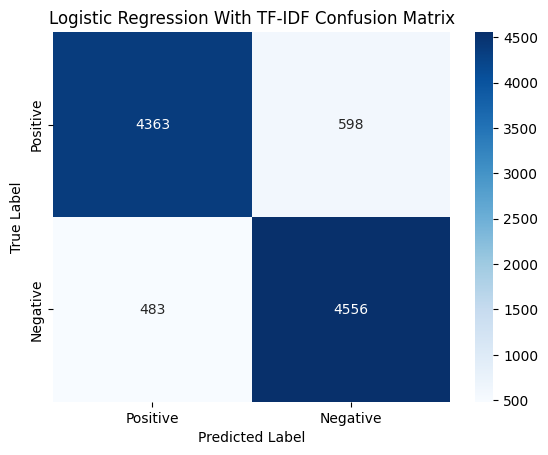

In [48]:
# Confusion matrix
cm = confusion_matrix(y_test, logreg_tfidf_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Logistic Regression With TF-IDF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Word2Vec

In [49]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_normalized, y, test_size=0.2, random_state=42)

# Naive Bayes Model
logreg_w2v_model = LogisticRegression()
logreg_w2v_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_w2v_predictions = logreg_w2v_model.predict(X_test)
logreg_w2v_accuracy = accuracy_score(y_test, logreg_w2v_predictions)
logreg_w2v_precision = precision_score(y_test, logreg_w2v_predictions)
logreg_w2v_recall = recall_score(y_test, logreg_w2v_predictions)
logreg_w2v_f1 = f1_score(y_test, logreg_w2v_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
print('Logreg with Word2Vec')
print("Accuracy:", logreg_w2v_accuracy)
print("Precision:", logreg_w2v_precision)
print("Recall:", logreg_w2v_recall)
print("F1 Score:", logreg_w2v_f1)

Logreg with Word2Vec
Accuracy: 0.8743
Precision: 0.8720975993703266
Recall: 0.8795395911887279
F1 Score: 0.8758027862859402


In [51]:
print(classification_report(y_test, logreg_w2v_predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4961
           1       0.87      0.88      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



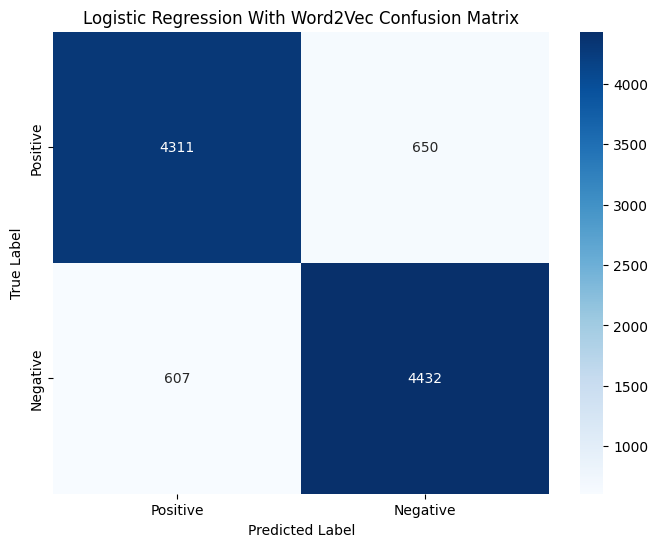

In [52]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, logreg_w2v_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Logistic Regression With Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### TF-IDF & Word2Vec Combined

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Naive Bayes Model
logreg_combined_model = LogisticRegression()
logreg_combined_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_combined_predictions = logreg_combined_model.predict(X_test)
logreg_combined_accuracy = accuracy_score(y_test, logreg_combined_predictions)
logreg_combined_precision = precision_score(y_test, logreg_combined_predictions)
logreg_combined_recall = recall_score(y_test, logreg_combined_predictions)
logreg_combined_f1 = f1_score(y_test, logreg_combined_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
print('Logreg with TF-IDF and Word2Vec')
print("Accuracy:", logreg_combined_accuracy)
print("Precision:", logreg_combined_precision)
print("Recall:", logreg_combined_recall)
print("F1 Score:", logreg_combined_f1)

Logreg with TF-IDF and Word2Vec
Accuracy: 0.8944
Precision: 0.890873405299313
Recall: 0.9007739630879142
F1 Score: 0.8957963291888692


In [55]:
print(classification_report(y_test, logreg_combined_predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4961
           1       0.89      0.90      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



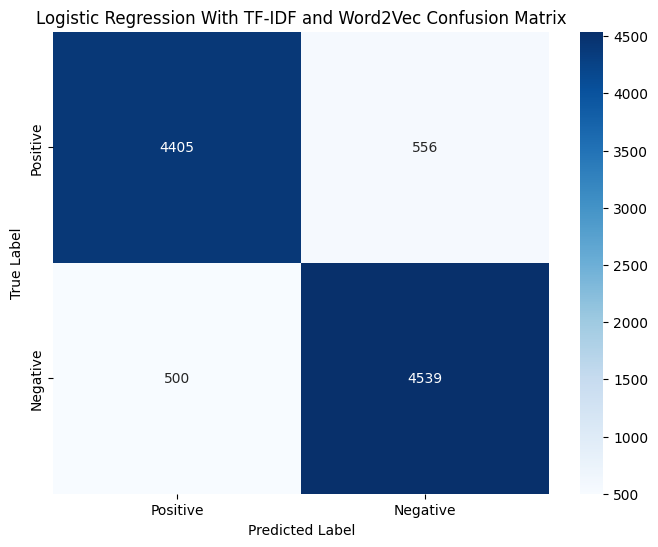

In [56]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, logreg_combined_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Logistic Regression With TF-IDF and Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Save Metrics

In [57]:
data = {
    'accuracy': [logreg_tfidf_accuracy, logreg_w2v_accuracy, logreg_combined_accuracy],
    'precision': [logreg_tfidf_precision, logreg_w2v_precision, logreg_combined_precision],
    'recall': [logreg_tfidf_recall, logreg_w2v_recall, logreg_combined_recall],
    'f1': [logreg_tfidf_f1, logreg_w2v_f1, logreg_combined_f1]
}

# Create a DataFrame from the dictionary
df_logreg = pd.DataFrame(data, index=['TF-IDF', 'Word2Vec', 'Combined'])

df_logreg.to_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/metrics/logreg.csv')
# df_logreg.to_csv('metrics/logreg.csv')

### SVM

#### TF-IDF

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
svm_tfidf_model = SVC(kernel='linear')
svm_tfidf_model.fit(X_train, y_train)

# Predictions and evaluation
svm_tfidf_predictions = svm_tfidf_model.predict(X_test)
svm_tfidf_accuracy = accuracy_score(y_test, svm_tfidf_predictions)
svm_tfidf_precision = precision_score(y_test, svm_tfidf_predictions)
svm_tfidf_recall = recall_score(y_test, svm_tfidf_predictions)
svm_tfidf_f1 = f1_score(y_test, svm_tfidf_predictions)

In [59]:
# Print the evaluation metrics
print('SVM Evaluation')
print("Accuracy:", svm_tfidf_accuracy)
print("Precision:", svm_tfidf_precision)
print("Recall:", svm_tfidf_recall)
print("F1 Score:", svm_tfidf_f1)

SVM Evaluation
Accuracy: 0.8894
Precision: 0.8829600778967868
Recall: 0.8997817027187934
F1 Score: 0.8912915274228425


In [60]:
print(classification_report(y_test, svm_tfidf_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



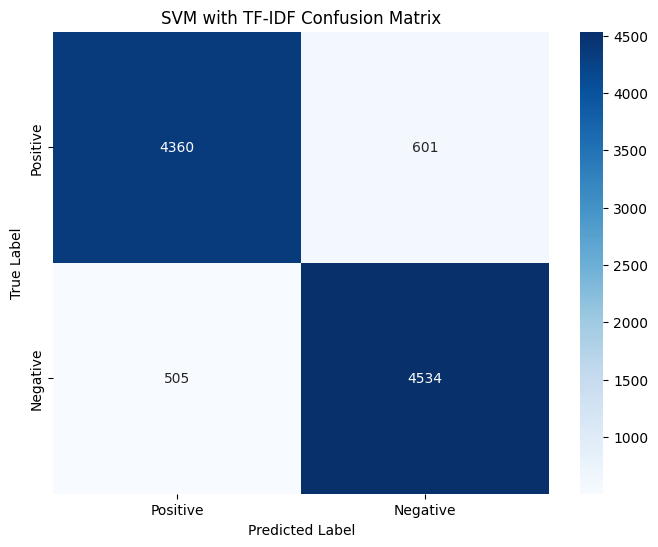

In [61]:
# Confusion matrix for SVM
svm_conf_matrix = confusion_matrix(y_test, svm_tfidf_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('SVM with TF-IDF Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Word2Vec

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_normalized, y, test_size=0.2, random_state=42)

# Naive Bayes Model
svm_w2v_model = SVC(kernel='linear')
svm_w2v_model.fit(X_train, y_train)

# Predictions and evaluation
svm_w2v_predictions = svm_w2v_model.predict(X_test)
svm_w2v_accuracy = accuracy_score(y_test, svm_w2v_predictions)
svm_w2v_precision = precision_score(y_test, svm_w2v_predictions)
svm_w2v_recall = recall_score(y_test, svm_w2v_predictions)
svm_w2v_f1 = f1_score(y_test, svm_w2v_predictions)

In [63]:
print('SVM with Word2Vec')
print("Accuracy:", svm_w2v_accuracy)
print("Precision:", svm_w2v_precision)
print("Recall:", svm_w2v_recall)
print("F1 Score:", svm_w2v_f1)

SVM with Word2Vec
Accuracy: 0.8733
Precision: 0.8711137347500983
Recall: 0.8785473308196071
F1 Score: 0.8748147416263216


In [64]:
print(classification_report(y_test, svm_w2v_predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



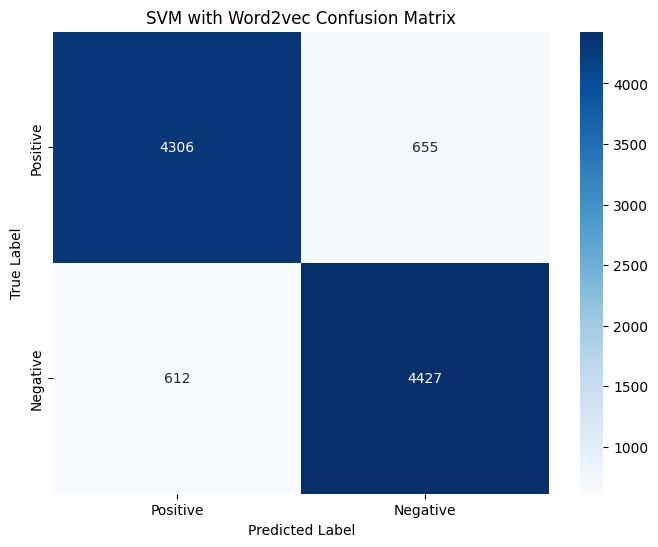

In [65]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, svm_w2v_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('SVM with Word2vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### TF-IDF & Word2Vec Combined

In [66]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Naive Bayes Model
svm_combined_model = SVC(kernel='linear')
svm_combined_model.fit(X_train, y_train)

# Predictions and evaluation
svm_combined_predictions = svm_combined_model.predict(X_test)
svm_combined_accuracy = accuracy_score(y_test, svm_combined_predictions)
svm_combined_precision = precision_score(y_test, svm_combined_predictions)
svm_combined_recall = recall_score(y_test, svm_combined_predictions)
svm_combined_f1 = f1_score(y_test, svm_combined_predictions)

In [67]:
print('SVM with TF-IDF and Word2Vec')
print("Accuracy:", svm_combined_accuracy)
print("Precision:", svm_combined_precision)
print("Recall:", svm_combined_recall)
print("F1 Score:", svm_combined_f1)

SVM with TF-IDF and Word2Vec
Accuracy: 0.8949
Precision: 0.8925196850393701
Recall: 0.8997817027187934
F1 Score: 0.8961359818163851


In [68]:
print(classification_report(y_test, svm_combined_predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4961
           1       0.89      0.90      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



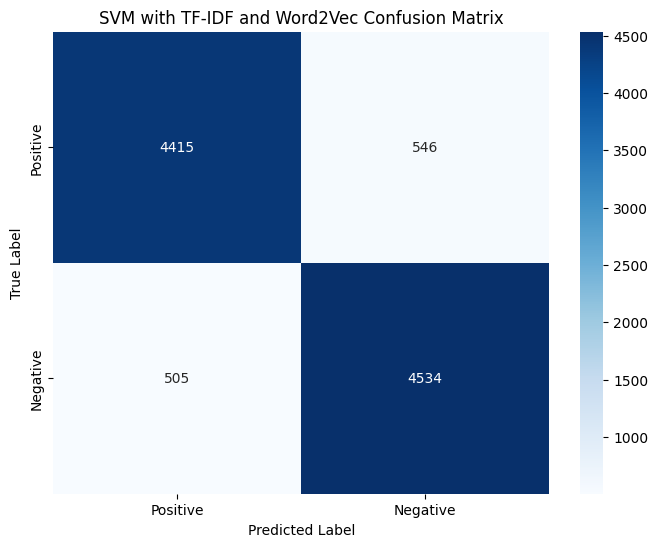

In [69]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, svm_combined_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('SVM with TF-IDF and Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Save Metrics

In [70]:
data = {
    'accuracy': [svm_tfidf_accuracy, svm_w2v_accuracy, svm_combined_accuracy],
    'precision': [svm_tfidf_precision, svm_w2v_precision, svm_combined_precision],
    'recall': [svm_tfidf_recall, svm_w2v_recall, svm_combined_recall],
    'f1': [svm_tfidf_f1, svm_w2v_f1, svm_combined_f1]
}

# Create a DataFrame from the dictionary
df_svm = pd.DataFrame(data, index=['TF-IDF', 'Word2Vec', 'Combined'])

df_svm.to_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/metrics/svm.csv')
# df_svm.to_csv('metrics/svm.csv')

### Naive Bayes

#### TF=IDF

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
nb_tfidf_model = MultinomialNB()
nb_tfidf_model.fit(X_train, y_train)

# Predictions and evaluation
nb_tfidf_predictions = nb_tfidf_model.predict(X_test)
nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf_predictions)
nb_tfidf_precision = precision_score(y_test, nb_tfidf_predictions)
nb_tfidf_recall = recall_score(y_test, nb_tfidf_predictions)
nb_tfidf_f1 = f1_score(y_test, nb_tfidf_predictions)

In [33]:
# Print the evaluation metrics
print('NB with TF-IDF')
print("Accuracy:", nb_tfidf_accuracy)
print("Precision:", nb_tfidf_precision)
print("Recall:", nb_tfidf_recall)
print("F1 Score:", nb_tfidf_f1)

NB with TF-IDF
Accuracy: 0.8547
Precision: 0.8557539682539682
Recall: 0.8559237944036515
F1 Score: 0.8558388729040579


In [34]:
print( classification_report(y_test, nb_tfidf_predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.86      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



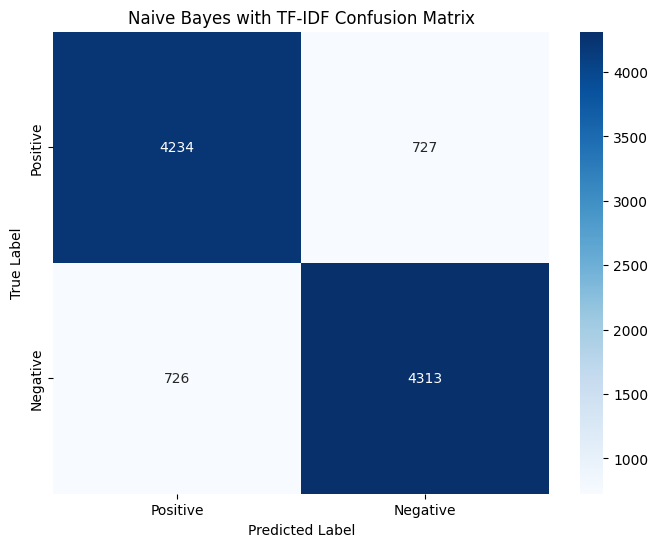

In [35]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_tfidf_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes with TF-IDF Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Word2Vec

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_normalized, y, test_size=0.2, random_state=42)

# Naive Bayes Model
nb_w2v_model = MultinomialNB()
nb_w2v_model.fit(X_train, y_train)

# Predictions and evaluation
nb_w2v_predictions = nb_w2v_model.predict(X_test)
nb_w2v_accuracy = accuracy_score(y_test, nb_w2v_predictions)
nb_w2v_precision = precision_score(y_test, nb_w2v_predictions)
nb_w2v_recall = recall_score(y_test, nb_w2v_predictions)
nb_w2v_f1 = f1_score(y_test, nb_w2v_predictions)


In [37]:
print('NB with Word2Vec')
print("Accuracy:", nb_w2v_accuracy)
print("Precision:", nb_w2v_precision)
print("Recall:", nb_w2v_recall)
print("F1 Score:", nb_w2v_f1)


NB with Word2Vec
Accuracy: 0.7698
Precision: 0.776856160226583
Recall: 0.7620559634848184
F1 Score: 0.7693848928070527


In [38]:
print( classification_report(y_test, nb_w2v_predictions))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      4961
           1       0.78      0.76      0.77      5039

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



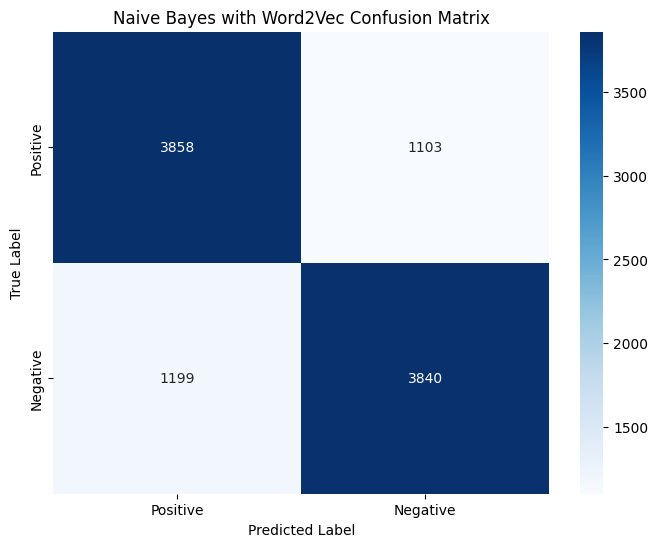

In [39]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_w2v_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes with Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### TF-IDF & Word2Vec Combined

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Naive Bayes Model
nb_combined_model = MultinomialNB()
nb_combined_model.fit(X_train, y_train)

# Predictions and evaluation
nb_combined_predictions = nb_combined_model.predict(X_test)
nb_combined_accuracy = accuracy_score(y_test, nb_combined_predictions)
nb_combined_precision = precision_score(y_test, nb_combined_predictions)
nb_combined_recall = recall_score(y_test, nb_combined_predictions)
nb_combined_f1 = f1_score(y_test, nb_combined_predictions)

In [41]:
print('NB with TF-IDF and Word2Vec')
print("Accuracy:", nb_combined_accuracy)
print("Precision:", nb_combined_precision)
print("Recall:", nb_combined_recall)
print("F1 Score:", nb_combined_f1)

NB with TF-IDF and Word2Vec
Accuracy: 0.8518
Precision: 0.8485204781501078
Recall: 0.8592974796586624
F1 Score: 0.8538749753500295


In [42]:
print( classification_report(y_test, nb_combined_predictions))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



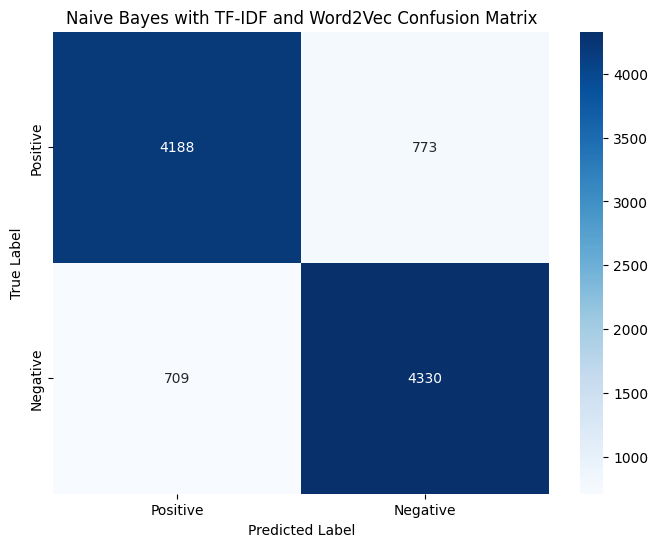

In [43]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_combined_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Naive Bayes with TF-IDF and Word2Vec Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Save Metrics

In [44]:
data = {
    'accuracy': [nb_tfidf_accuracy, nb_w2v_accuracy, nb_combined_accuracy],
    'precision': [nb_tfidf_precision, nb_w2v_precision, nb_combined_precision],
    'recall': [nb_tfidf_recall, nb_w2v_recall, nb_combined_recall],
    'f1': [nb_tfidf_f1, nb_w2v_f1, nb_combined_f1]
}

# Create a DataFrame from the dictionary
df_nb = pd.DataFrame(data, index=['TF-IDF', 'Word2Vec', 'Combined'])

df_nb.to_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/metrics/naivebayes.csv')
# df_nb.to_csv('metrics/naivebayes.csv')

### BILSTM

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

import time
import json

#### Utils

In [27]:
# Training function at each epoch
def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader.dataset)

def predicting(model, device, loader, loss_fn):
    test_outputs_list = []
    test_labels_list = []
    model.eval()
    total_loss = 0
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    with torch.no_grad():
        for embeddings, labels in loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            total_loss_test = total_loss / len(loader.dataset)

            predicted = (outputs > 0.5).float()
            test_outputs_list.append(predicted)
            test_labels_list.append(labels)

    return total_loss_test, test_outputs_list, test_labels_list

In [28]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2vec):
        self.reviews = reviews
        self.labels = labels
        self.word2vec = word2vec

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        # Convert words to their corresponding embeddings
        words = self.reviews[idx]
        embeddings = [self.word2vec.wv[word] for word in words if word in self.word2vec.wv]

        # Convert list of numpy arrays to a single numpy array before converting to tensor
        embeddings = np.array(embeddings, dtype=np.float32)

        embeddings = torch.tensor(embeddings, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return embeddings, label

def collate_fn(batch):
    # Sort the batch in the descending order of sequence length
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, labels = zip(*batch)
    # Pad the sequences to have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels

Clear CUDA Memory

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# import gc
# gc.collect()

#### MODEL

In [29]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5) # Dropout layer

    def forward(self, x):
        # Computing the packed sequence of embeddings
        packed_output, (hidden, cell) = self.lstm(x)
        # Concatenate the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped = self.dropout(hidden)
        out = self.fc(dropped)
        return torch.sigmoid(out)

#### Model Init

In [47]:
# Define CUDA device name
cuda_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(cuda_name)
print('device:', device)

# Define other training parameters
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LR = 0.0001
NUM_EPOCHS = 50

# Hyperparameters
embedding_dim = 100  # As per Word2Vec setting
hidden_dim = 128
output_dim = 1
num_layers = 2

# Initialize model, loss, and optimizer
model = BiLSTM(embedding_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
loss_fn = nn.BCELoss()

# Early Stopping Setup
early_stopping_patience = 5
early_stopping_counter = 0
min_val_loss = float('inf')

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=3)

device: cuda:0


#### SPLIT DATASET

In [31]:
# Split the data into training, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(sentences, df['sentiment'].values, test_size=0.2, random_state=42, stratify=df['sentiment'].values)
# val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_size, random_state=42, stratify=train_labels)

# Create Datasets
train_dataset = IMDBDataset(train_data, train_labels, word2vec_model)
val_dataset = IMDBDataset(val_data, val_labels, word2vec_model)
test_dataset = IMDBDataset(test_data, test_labels, word2vec_model)

print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

Training set size: 32000 samples
Validation set size: 8000 samples
Test set size: 10000 samples


#### Data Loader

In [48]:
# Data preparation and loaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False,  collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,  collate_fn=collate_fn)
print("Data loaders initialized.")

Data loaders initialized.


#### Training

In [49]:
# store metrics
train_losses, val_losses, eval_metrics = [], [], []

print('cuda_name:', cuda_name)
print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)
print('Running on: ', BiLSTM.__name__)
print('\n')

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    print(f'Epoch {epoch}:')

    print('Training on {} samples...'.format(len(train_loader.dataset)))
    train_loss = train(model, device, train_loader, optimizer, loss_fn)
    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    print('Validation on for {} samples...'.format(len(val_loader.dataset)))
    val_loss, labels, preds = predicting(model, device, val_loader, loss_fn)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')
    # Evaluation metrics
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    accuracy = accuracy_score(labels.cpu(), preds.cpu())
    precision = precision_score(labels.cpu(), preds.cpu())
    recall = recall_score(labels.cpu(), preds.cpu())
    f1 = f1_score(labels.cpu(), preds.cpu())
    eval_metrics.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    # Adjust learning rate based on validation loss
    print('Adjusting learning rate based on validation loss...')
    last_lr = scheduler.get_last_lr()
    scheduler.step(val_loss)
    current_lr = scheduler.get_last_lr()
    print(f'Last LR: {last_lr} | Current LR: {current_lr}')

    # Calculate epoch duration
    end_time = time.time()
    duration_seconds = int(end_time - start_time)
    hours = duration_seconds // 3600
    minutes = (duration_seconds % 3600) // 60
    seconds = duration_seconds % 60
    print(f'Training Duration: {hours}h:{minutes}m:{seconds}s\n')

    # Early Stopping Check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

cuda_name: cuda:0
Learning rate:  0.0001
Epochs:  50
Running on:  BiLSTM


Epoch 1:
Training on 32000 samples...
Training Loss: 0.0144
Validation on for 8000 samples...
Validation Loss: 0.0123
Accuracy: 0.8283, Precision: 0.7245, Recall: 0.9142, F1: 0.8084
Adjusting learning rate based on validation loss...
Last LR: [0.0001] | Current LR: [0.0001]
Training Duration: 0h:2m:8s

Epoch 2:
Training on 32000 samples...
Training Loss: 0.0107
Validation on for 8000 samples...
Validation Loss: 0.0098
Accuracy: 0.8760, Precision: 0.8582, Recall: 0.8898, F1: 0.8738
Adjusting learning rate based on validation loss...
Last LR: [0.0001] | Current LR: [0.0001]
Training Duration: 0h:2m:11s

Epoch 3:
Training on 32000 samples...
Training Loss: 0.0104
Validation on for 8000 samples...
Validation Loss: 0.0101
Accuracy: 0.8668, Precision: 0.8353, Recall: 0.8914, F1: 0.8624
Adjusting learning rate based on validation loss...
Last LR: [0.0001] | Current LR: [0.0001]
Training Duration: 0h:2m:15s

Epoch 4:
Tr

#### Saved Model & Metrics

In [ ]:
# cuda_name: cuda:0
# Learning rate:  0.0001
# Epochs:  50
# Running on:  BiLSTM


# Epoch 1:
# Training on 32000 samples...
# Training Loss: 0.0167
# Validation on for 8000 samples...
# Validation Loss: 0.0152
# Accuracy: 0.7881, Precision: 0.7235, Recall: 0.8309, F1: 0.7735
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:17s

# Epoch 2:
# Training on 32000 samples...
# Training Loss: 0.0141
# Validation on for 8000 samples...
# Validation Loss: 0.0138
# Accuracy: 0.8055, Precision: 0.9285, Recall: 0.7452, F1: 0.8268
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:27s

# Epoch 3:
# Training on 32000 samples...
# Training Loss: 0.0125
# Validation on for 8000 samples...
# Validation Loss: 0.0112
# Accuracy: 0.8511, Precision: 0.8510, Recall: 0.8512, F1: 0.8511
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:44s

# Epoch 4:
# Training on 32000 samples...
# Training Loss: 0.0115
# Validation on for 8000 samples...
# Validation Loss: 0.0104
# Accuracy: 0.8592, Precision: 0.8502, Recall: 0.8658, F1: 0.8580
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:45s

# Epoch 5:
# Training on 32000 samples...
# Training Loss: 0.0124
# Validation on for 8000 samples...
# Validation Loss: 0.0131
# Accuracy: 0.8365, Precision: 0.7632, Recall: 0.8943, F1: 0.8236
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:43s

# Epoch 6:
# Training on 32000 samples...
# Training Loss: 0.0119
# Validation on for 8000 samples...
# Validation Loss: 0.0109
# Accuracy: 0.8616, Precision: 0.8705, Recall: 0.8553, F1: 0.8628
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:42s

# Epoch 7:
# Training on 32000 samples...
# Training Loss: 0.0107
# Validation on for 8000 samples...
# Validation Loss: 0.0096
# Accuracy: 0.8740, Precision: 0.8695, Recall: 0.8774, F1: 0.8734
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:44s

# Epoch 8:
# Training on 32000 samples...
# Training Loss: 0.0101
# Validation on for 8000 samples...
# Validation Loss: 0.0093
# Accuracy: 0.8806, Precision: 0.8662, Recall: 0.8919, F1: 0.8789
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:48s

# Epoch 9:
# Training on 32000 samples...
# Training Loss: 0.0097
# Validation on for 8000 samples...
# Validation Loss: 0.0092
# Accuracy: 0.8801, Precision: 0.8955, Recall: 0.8688, F1: 0.8819
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:43s

# Epoch 10:
# Training on 32000 samples...
# Training Loss: 0.0094
# Validation on for 8000 samples...
# Validation Loss: 0.0088
# Accuracy: 0.8844, Precision: 0.8880, Recall: 0.8816, F1: 0.8848
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:52s

# Epoch 11:
# Training on 32000 samples...
# Training Loss: 0.0090
# Validation on for 8000 samples...
# Validation Loss: 0.0086
# Accuracy: 0.8865, Precision: 0.8838, Recall: 0.8886, F1: 0.8862
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:51s

# Epoch 12:
# Training on 32000 samples...
# Training Loss: 0.0089
# Validation on for 8000 samples...
# Validation Loss: 0.0087
# Accuracy: 0.8856, Precision: 0.9165, Recall: 0.8632, F1: 0.8891
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:48s

# Epoch 13:
# Training on 32000 samples...
# Training Loss: 0.0085
# Validation on for 8000 samples...
# Validation Loss: 0.0089
# Accuracy: 0.8782, Precision: 0.8253, Recall: 0.9231, F1: 0.8714
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:46s

# Epoch 14:
# Training on 32000 samples...
# Training Loss: 0.0083
# Validation on for 8000 samples...
# Validation Loss: 0.0086
# Accuracy: 0.8866, Precision: 0.9287, Recall: 0.8566, F1: 0.8912
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:46s

# Epoch 15:
# Training on 32000 samples...
# Training Loss: 0.0081
# Validation on for 8000 samples...
# Validation Loss: 0.0082
# Accuracy: 0.8898, Precision: 0.8848, Recall: 0.8937, F1: 0.8892
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:59s

# Epoch 16:
# Training on 32000 samples...
# Training Loss: 0.0078
# Validation on for 8000 samples...
# Validation Loss: 0.0081
# Accuracy: 0.8920, Precision: 0.9110, Recall: 0.8776, F1: 0.8940
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:48s

# Epoch 17:
# Training on 32000 samples...
# Training Loss: 0.0076
# Validation on for 8000 samples...
# Validation Loss: 0.0086
# Accuracy: 0.8872, Precision: 0.9317, Recall: 0.8556, F1: 0.8921
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:49s

# Epoch 18:
# Training on 32000 samples...
# Training Loss: 0.0074
# Validation on for 8000 samples...
# Validation Loss: 0.0081
# Accuracy: 0.8939, Precision: 0.9000, Recall: 0.8891, F1: 0.8945
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:45s

# Epoch 19:
# Training on 32000 samples...
# Training Loss: 0.0072
# Validation on for 8000 samples...
# Validation Loss: 0.0088
# Accuracy: 0.8872, Precision: 0.8405, Recall: 0.9272, F1: 0.8817
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [0.0001]
# Training Duration: 0h:2m:46s

# Epoch 20:
# Training on 32000 samples...
# Training Loss: 0.0068
# Validation on for 8000 samples...
# Validation Loss: 0.0086
# Accuracy: 0.8935, Precision: 0.8850, Recall: 0.9003, F1: 0.8926
# Adjusting learning rate based on validation loss...
# Last LR: [0.0001] | Current LR: [1.0000000000000002e-06]
# Training Duration: 0h:2m:48s

# Epoch 21:
# Training on 32000 samples...
# Training Loss: 0.0063
# Validation on for 8000 samples...
# Validation Loss: 0.0082
# Accuracy: 0.8954, Precision: 0.8978, Recall: 0.8935, F1: 0.8956
# Adjusting learning rate based on validation loss...
# Last LR: [1.0000000000000002e-06] | Current LR: [1.0000000000000002e-06]
# Training Duration: 0h:2m:46s

# Early stopping triggered.


In [50]:
torch.save(model.state_dict(), 'model/bilstm_50k-neww2v-50epoch-earlystop50epoch-split80-32batch.pth')
print("Model saved.")

Model saved.


In [51]:
import pickle
# Define the file path to save the data
file_path = 'metrics/bilstm_50k-neww2v-50epoch-earlystop50epoch-split80-32batch.pkl'

# Create a dictionary to store the data
data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'eval_metrics': eval_metrics
}

# Save the data to a file using pickle
with open(file_path, 'wb') as f:
    pickle.dump(data, f)

print('Metrics saved successfully.')

Metrics saved successfully.


#### Load Models & Metrics

In [52]:
model.load_state_dict(torch.load('model/bilstm_50k-neww2v-50epoch-earlystop50epoch-split80-32batch.pth'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/bilstm_50k_new.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [53]:
import pickle
# file_path = '/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/metrics/bilstm_50k_new.pkl'
file_path = 'metrics/bilstm_50k-neww2v-50epoch-earlystop50epoch-split80-32batch.pkl'

with open(file_path, 'rb') as f:
    metrics = pickle.load(f)
    print('Metrics loaded successfully.')

Metrics loaded successfully.


In [54]:
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
eval_metrics = metrics['eval_metrics']

#### Evaluating

In [55]:
print('Testing on for {} samples...'.format(len(test_loader.dataset)))
test_loss, labels, preds = predicting(model, device, test_loader, loss_fn)
print(f'Testing Loss: {test_loss:.4f}')

preds = torch.cat(preds)
labels = torch.cat(labels)
bilstm_accuracy = accuracy_score(labels.cpu(), preds.cpu())
bilstm_precision = precision_score(labels.cpu(), preds.cpu())
bilstm_recall = recall_score(labels.cpu(), preds.cpu())
bilstm_f1 = f1_score(labels.cpu(), preds.cpu())

print('Testing Evaluation Metrics')
print(f'Accuracy: {bilstm_accuracy:.4f}, Precision: {bilstm_precision:.4f}, Recall: {bilstm_recall:.4f}, F1: {bilstm_f1:.4f}')

Testing on for 10000 samples...
Testing Loss: 0.0088
Testing Evaluation Metrics
Accuracy: 0.8871, Precision: 0.8886, Recall: 0.8859, F1: 0.8873


In [71]:
data = {
    'accuracy': [bilstm_accuracy],
    'precision': [bilstm_precision],
    'recall': [bilstm_recall],
    'f1': [bilstm_f1]
}

# Create a DataFrame from the dictionary
df_bilstm = pd.DataFrame(data, index=['BiLSTM'])
# df_bilstm.to_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/metrics/bilstm.csv')
df_bilstm.to_csv('metrics/bilstm.csv')

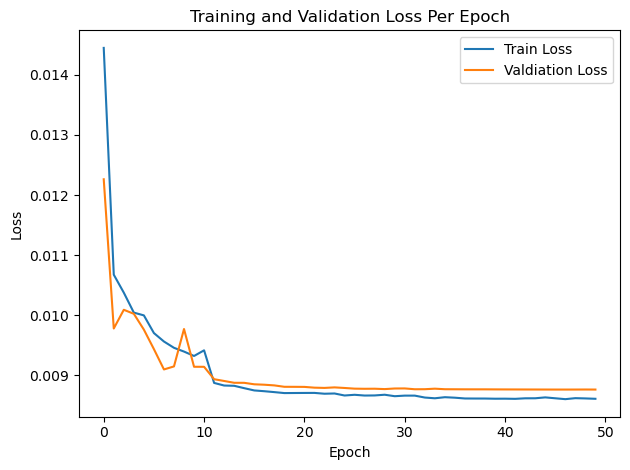

In [56]:
# Extract metrics
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

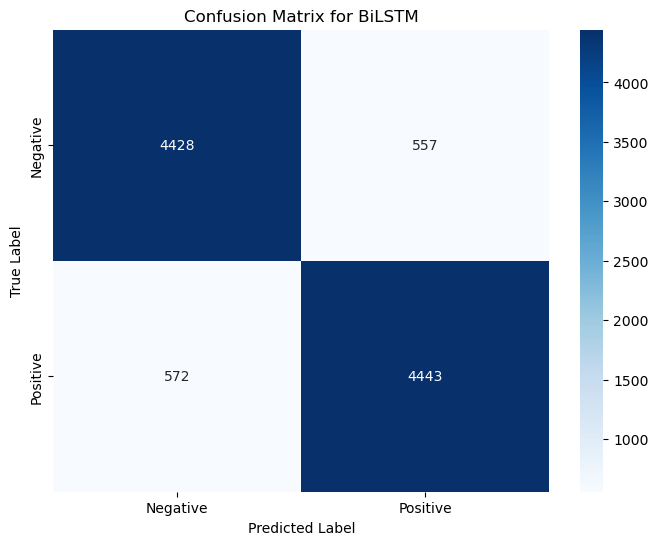

In [74]:
cm = confusion_matrix(labels.cpu(), preds.cpu())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for BiLSTM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Metrics Model Comparison

## Feature Extraction Comparison

In [72]:
df_logreg = pd.read_csv('metrics/logreg.csv')
df_nb = pd.read_csv('metrics/naivebayes.csv')
df_svm = pd.read_csv('metrics/svm.csv')
df_bilstm = pd.read_csv('metrics/bilstm.csv')


In [73]:
df_logreg.head(), df_nb.head(), df_svm.head(), df_bilstm.head()

(  Unnamed: 0  accuracy  precision    recall        f1
 0     TF-IDF    0.8919   0.883974  0.904148  0.893947
 1   Word2Vec    0.8743   0.872098  0.879540  0.875803
 2   Combined    0.8944   0.890873  0.900774  0.895796,
   Unnamed: 0  accuracy  precision    recall        f1
 0     TF-IDF    0.8547   0.855754  0.855924  0.855839
 1   Word2Vec    0.7698   0.776856  0.762056  0.769385
 2   Combined    0.8518   0.848520  0.859297  0.853875,
   Unnamed: 0  accuracy  precision    recall        f1
 0     TF-IDF    0.8894   0.882960  0.899782  0.891292
 1   Word2Vec    0.8733   0.871114  0.878547  0.874815
 2   Combined    0.8949   0.892520  0.899782  0.896136,
   Unnamed: 0  accuracy  precision    recall        f1
 0     BiLSTM    0.8871     0.8886  0.885942  0.887269)

### Logistic Regression

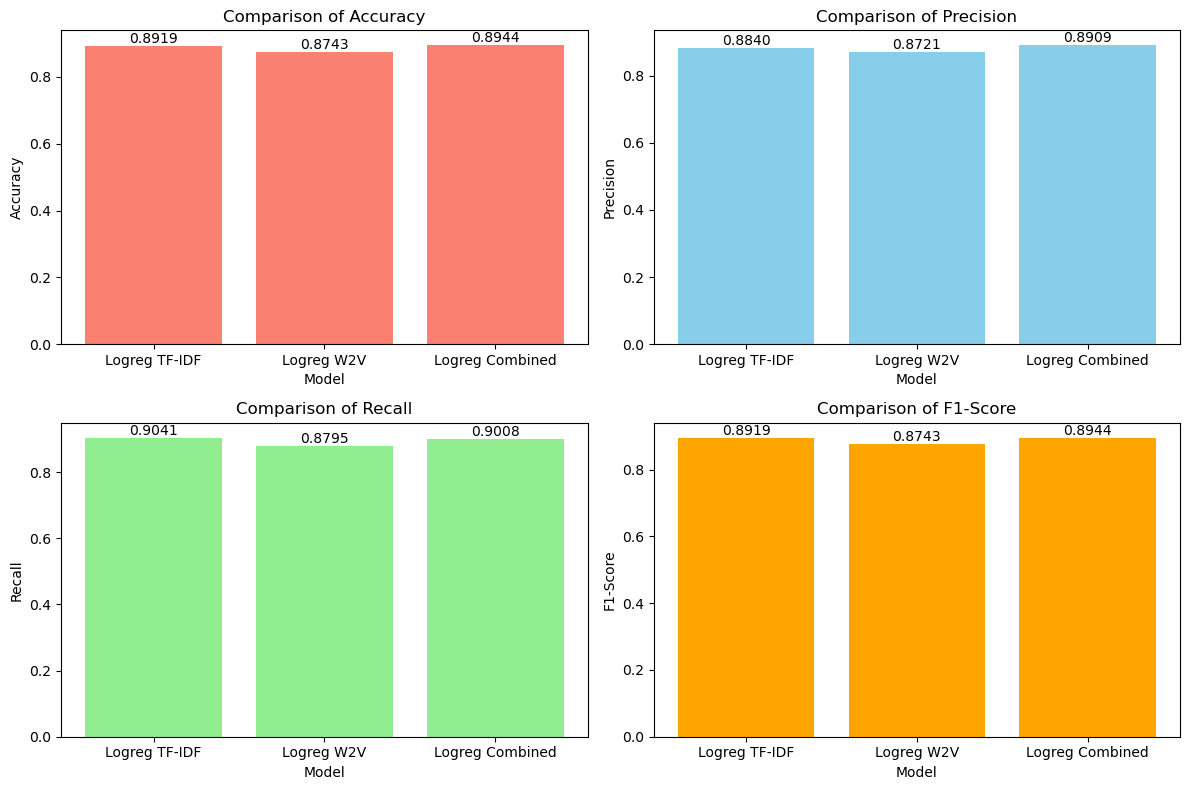

In [60]:
# Create a list of model names
model_names = ['Logreg TF-IDF', 'Logreg W2V', 'Logreg Combined']

# Extract merics values from the data dictionary
accuracy_values = df_logreg['accuracy']
precision_values = df_logreg['precision']
recall_values = df_logreg['recall']
f1_values = df_logreg['f1']

plt.figure(figsize=(12,8))

# Plot the accuracy values
plt.subplot(2,2,1)
plt.bar(model_names, accuracy_values, color='salmon')
for i in range(3):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')

# Plot the precision values
plt.subplot(2,2,2)
plt.bar(model_names, precision_values, color='skyblue')
for i in range(3):
    plt.text(i, precision_values[i], f'{precision_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision')

# Plot the recall values
plt.subplot(2,2,3)
plt.bar(model_names, recall_values, color='lightgreen')
for i in range(3):
    plt.text(i, recall_values[i], f'{recall_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall')


# Plot the f1 values
plt.subplot(2,2,4)
plt.bar(model_names, f1_values, color='orange')
for i in range(3):
    plt.text(i, f1_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Comparison of F1-Score')


plt.tight_layout()
plt.show()

### SVM

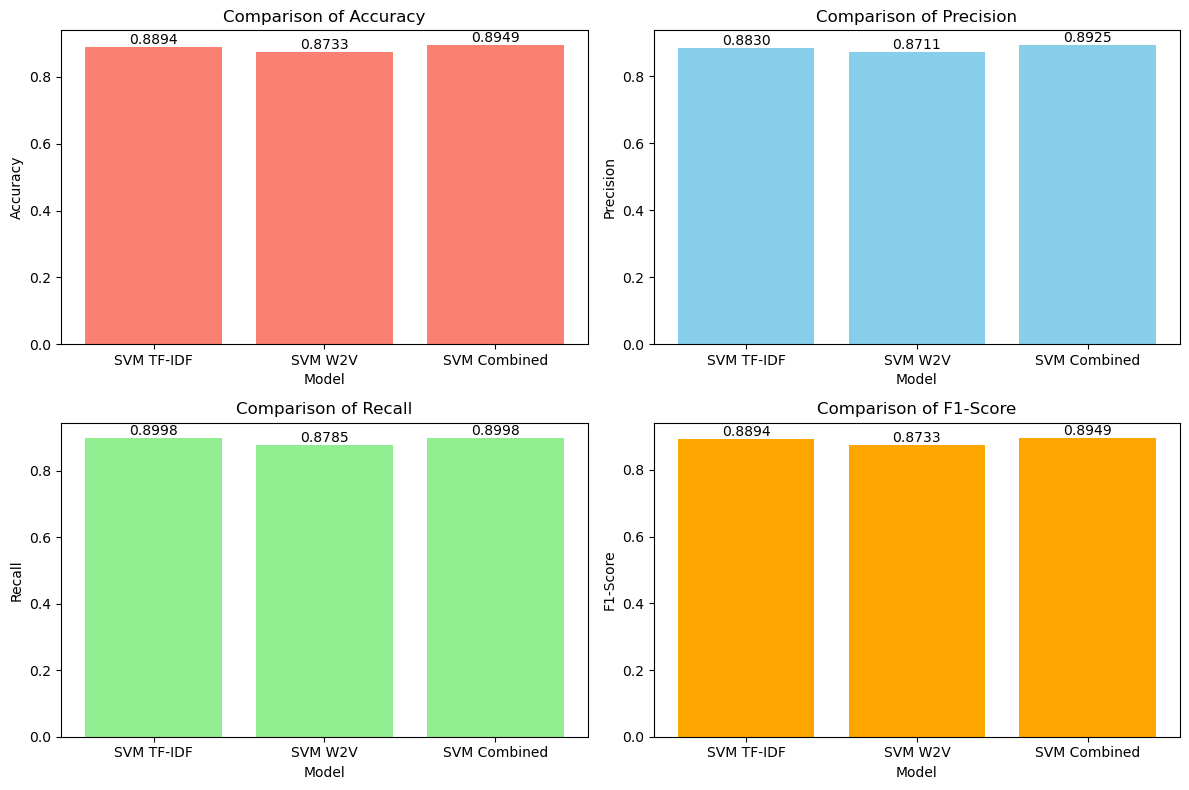

In [61]:
# Create a list of model names
model_names = ['SVM TF-IDF', 'SVM W2V', 'SVM Combined']

# Extract merics values from the data dictionary
accuracy_values = df_svm['accuracy']
precision_values = df_svm['precision']
recall_values = df_svm['recall']
f1_values = df_svm['f1']

plt.figure(figsize=(12,8))

# Plot the accuracy values
plt.subplot(2,2,1)
plt.bar(model_names, accuracy_values, color='salmon')
for i in range(3):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')

# Plot the precision values
plt.subplot(2,2,2)
plt.bar(model_names, precision_values, color='skyblue')
for i in range(3):
    plt.text(i, precision_values[i], f'{precision_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision')

# Plot the recall values
plt.subplot(2,2,3)
plt.bar(model_names, recall_values, color='lightgreen')
for i in range(3):
    plt.text(i, recall_values[i], f'{recall_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall')


# Plot the f1 values
plt.subplot(2,2,4)
plt.bar(model_names, f1_values, color='orange')
for i in range(3):
    plt.text(i, f1_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Comparison of F1-Score')


plt.tight_layout()
plt.show()

### Naive Bayes

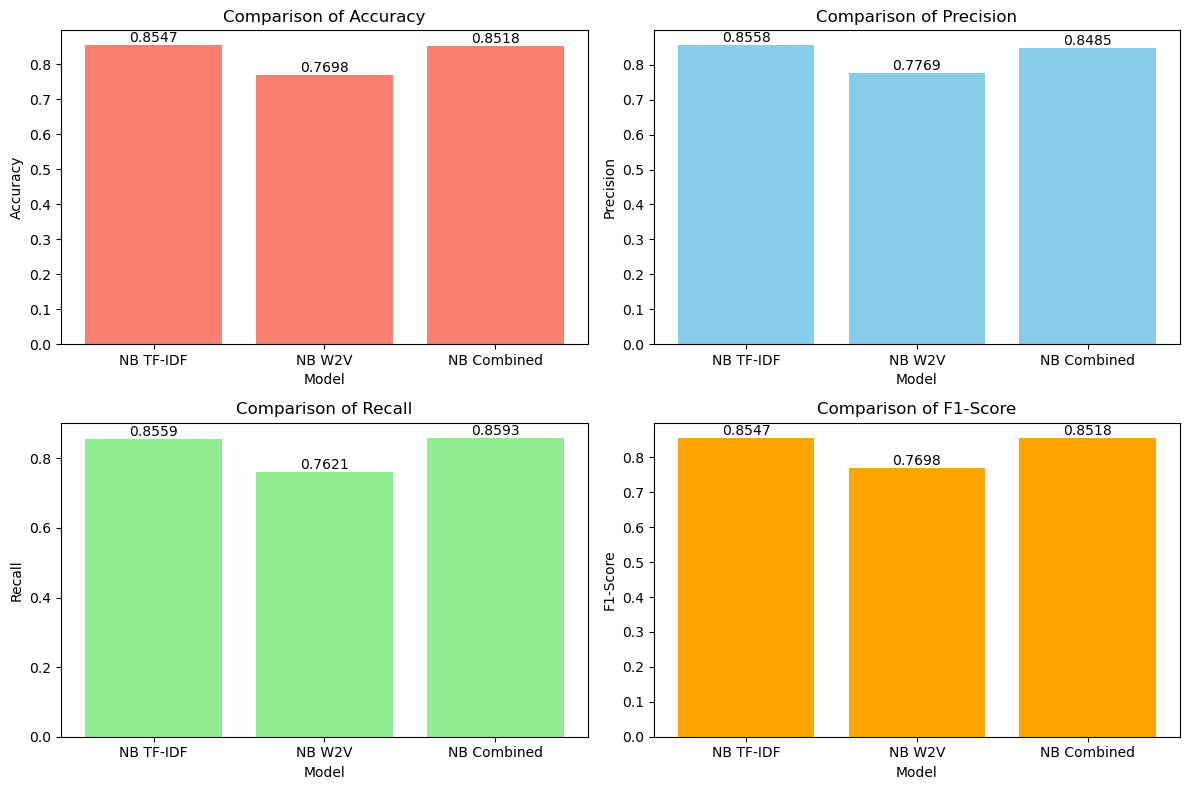

In [62]:
# Create a list of model names
model_names = ['NB TF-IDF', 'NB W2V', 'NB Combined']

# Extract merics values from the data dictionary
accuracy_values = df_nb['accuracy']
precision_values = df_nb['precision']
recall_values = df_nb['recall']
f1_values = df_nb['f1']

plt.figure(figsize=(12,8))

# Plot the accuracy values
plt.subplot(2,2,1)
plt.bar(model_names, accuracy_values, color='salmon')
for i in range(3):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')

# Plot the precision values
plt.subplot(2,2,2)
plt.bar(model_names, precision_values, color='skyblue')
for i in range(3):
    plt.text(i, precision_values[i], f'{precision_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision')

# Plot the recall values
plt.subplot(2,2,3)
plt.bar(model_names, recall_values, color='lightgreen')
for i in range(3):
    plt.text(i, recall_values[i], f'{recall_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall')


# Plot the f1 values
plt.subplot(2,2,4)
plt.bar(model_names, f1_values, color='orange')
for i in range(3):
    plt.text(i, f1_values[i], f'{accuracy_values[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Comparison of F1-Score')


plt.tight_layout()
plt.show()

## Model Comparison

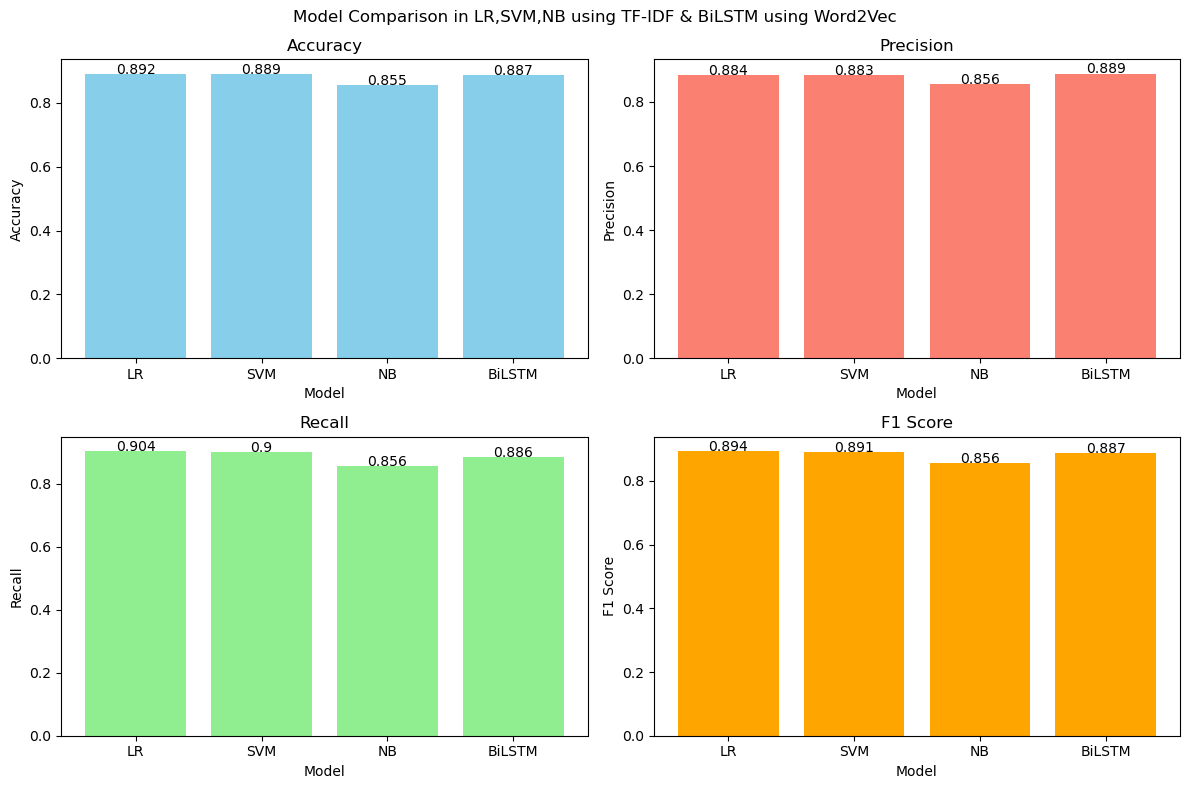

In [66]:
# plot all accuracy, precision, recall, f1 in bar
plt.figure(figsize=(12,8)).suptitle('Model Comparison in LR,SVM,NB using TF-IDF & BiLSTM using Word2Vec')
# fig=plt.figure()
# fig.suptitle('Comparison of using TF-IDF in ML & W2V in BiLSTM')


# Accuracy
plt.subplot(2,2,1)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['accuracy'][0], df_svm['accuracy'][0], df_nb['accuracy'][0], bilstm_accuracy], color='skyblue')
for i in range(4):
    plt.text(i, round([df_logreg['accuracy'][0], df_svm['accuracy'][0], df_nb['accuracy'][0], bilstm_accuracy][i], 3), round([df_logreg['accuracy'][0], df_svm['accuracy'][0], df_nb['accuracy'][0], bilstm_accuracy][i], 3), ha = 'center')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Precision
plt.subplot(2,2,2)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['precision'][0], df_svm['precision'][0], df_nb['precision'][0], bilstm_precision], color='salmon')
for i in range(4):
    plt.text(i, round([df_logreg['precision'][0], df_svm['precision'][0], df_nb['precision'][0], bilstm_precision][i], 3), round([df_logreg['precision'][0], df_svm['precision'][0], df_nb['precision'][0], bilstm_precision][i], 3), ha = 'center')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Precision')

# Recall
plt.subplot(2,2,3)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['recall'][0], df_svm['recall'][0], df_nb['recall'][0], bilstm_recall], color='lightgreen')
for i in range(4):
    plt.text(i, round([df_logreg['recall'][0], df_svm['recall'][0], df_nb['recall'][0], bilstm_recall][i], 3), round([df_logreg['recall'][0], df_svm['recall'][0], df_nb['recall'][0], bilstm_recall][i], 3), ha = 'center')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Recall')

# F1 Score
plt.subplot(2,2,4)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['f1'][0], df_svm['f1'][0], df_nb['f1'][0], bilstm_f1], color='orange')
for i in range(4):
    plt.text(i, round([df_logreg['f1'][0], df_svm['f1'][0], df_nb['f1'][0], bilstm_f1][i], 3), round([df_logreg['f1'][0], df_svm['f1'][0], df_nb['f1'][0], bilstm_f1][i], 3), ha = 'center')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

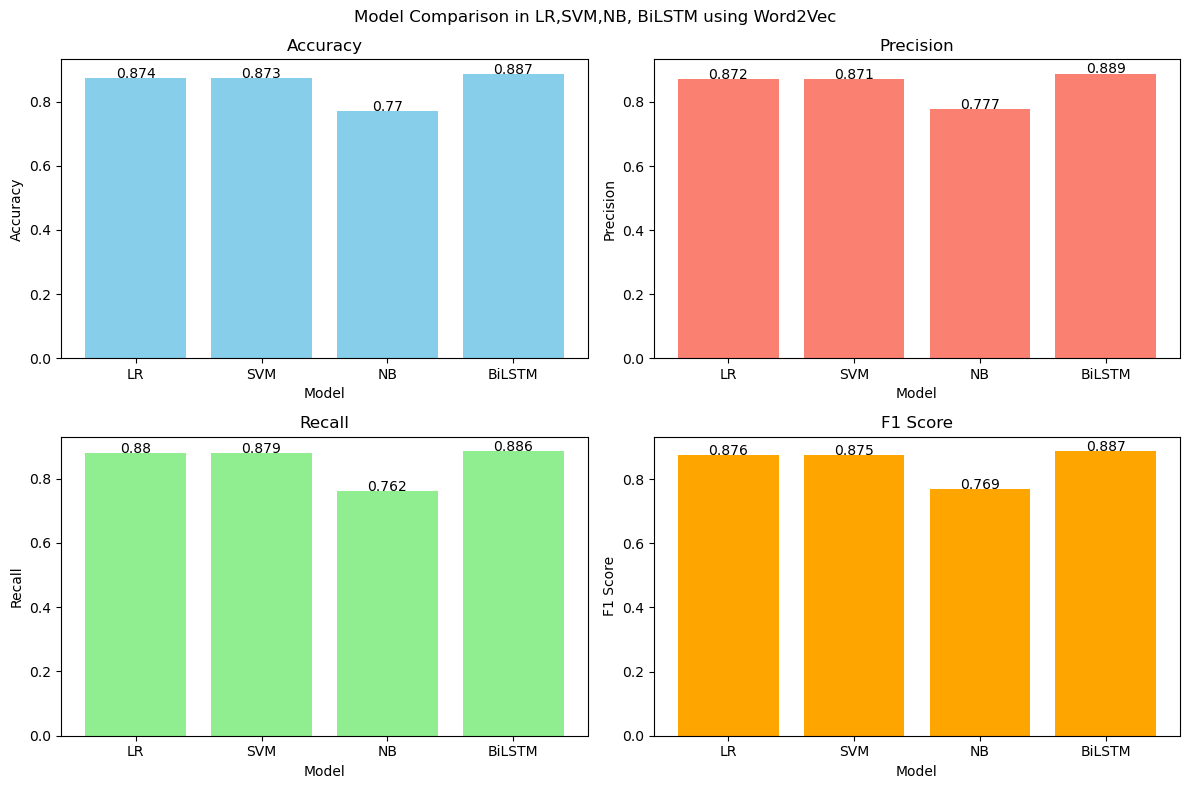

In [67]:
# plot all accuracy, precision, recall, f1 in bar
plt.figure(figsize=(12,8)).suptitle('Model Comparison in LR,SVM,NB, BiLSTM using Word2Vec')

# Accuracy
plt.subplot(2,2,1)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['accuracy'][1], df_svm['accuracy'][1], df_nb['accuracy'][1], bilstm_accuracy], color='skyblue')
for i in range(4):
    plt.text(i, round([df_logreg['accuracy'][1], df_svm['accuracy'][1], df_nb['accuracy'][1], bilstm_accuracy][i], 3), round([df_logreg['accuracy'][1], df_svm['accuracy'][1], df_nb['accuracy'][1], bilstm_accuracy][i], 3), ha = 'center')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Precision
plt.subplot(2,2,2)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['precision'][1], df_svm['precision'][1], df_nb['precision'][1], bilstm_precision], color='salmon')
for i in range(4):
    plt.text(i, round([df_logreg['precision'][1], df_svm['precision'][1], df_nb['precision'][1], bilstm_precision][i], 3), round([df_logreg['precision'][1], df_svm['precision'][1], df_nb['precision'][1], bilstm_precision][i], 3), ha = 'center')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Precision')

# Recall
plt.subplot(2,2,3)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['recall'][1], df_svm['recall'][1], df_nb['recall'][1], bilstm_recall], color='lightgreen')
for i in range(4):
    plt.text(i, round([df_logreg['recall'][1], df_svm['recall'][1], df_nb['recall'][1], bilstm_recall][i], 3), round([df_logreg['recall'][1], df_svm['recall'][1], df_nb['recall'][1], bilstm_recall][i], 3), ha = 'center')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Recall')

# F1 Score
plt.subplot(2,2,4)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['f1'][1], df_svm['f1'][1], df_nb['f1'][1], bilstm_f1], color='orange')
for i in range(4):
    plt.text(i, round([df_logreg['f1'][1], df_svm['f1'][1], df_nb['f1'][1], bilstm_f1][i], 3), round([df_logreg['f1'][1], df_svm['f1'][1], df_nb['f1'][1], bilstm_f1][i], 3), ha = 'center')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

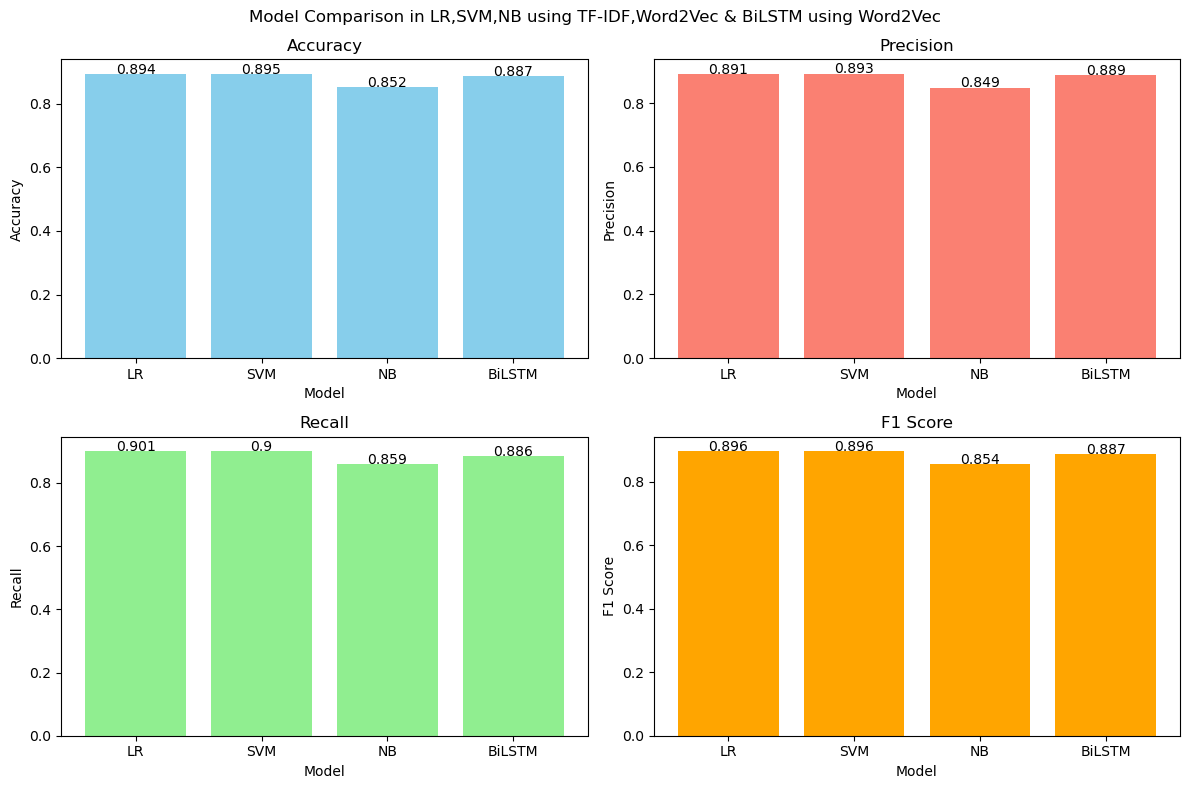

In [68]:
# plot all accuracy, precision, recall, f1 in bar
plt.figure(figsize=(12,8)).suptitle('Model Comparison in LR,SVM,NB using TF-IDF,Word2Vec & BiLSTM using Word2Vec')

# Accuracy
plt.subplot(2,2,1)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['accuracy'][2], df_svm['accuracy'][2], df_nb['accuracy'][2], bilstm_accuracy], color='skyblue')
for i in range(4):
    plt.text(i, round([df_logreg['accuracy'][2], df_svm['accuracy'][2], df_nb['accuracy'][2], bilstm_accuracy][i], 3), round([df_logreg['accuracy'][2], df_svm['accuracy'][2], df_nb['accuracy'][2], bilstm_accuracy][i], 3), ha = 'center')
plt.title('Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Precision
plt.subplot(2,2,2)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['precision'][2], df_svm['precision'][2], df_nb['precision'][2], bilstm_precision], color='salmon')
for i in range(4):
    plt.text(i, round([df_logreg['precision'][2], df_svm['precision'][2], df_nb['precision'][2], bilstm_precision][i], 3), round([df_logreg['precision'][2], df_svm['precision'][2], df_nb['precision'][2], bilstm_precision][i], 3), ha = 'center')
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('Precision')

# Recall
plt.subplot(2,2,3)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['recall'][2], df_svm['recall'][2], df_nb['recall'][2], bilstm_recall], color='lightgreen')
for i in range(4):
    plt.text(i, round([df_logreg['recall'][2], df_svm['recall'][2], df_nb['recall'][2], bilstm_recall][i], 3), round([df_logreg['recall'][2], df_svm['recall'][2], df_nb['recall'][2], bilstm_recall][i], 3), ha = 'center')
plt.title('Recall')
plt.xlabel('Model')
plt.ylabel('Recall')

# F1 Score
plt.subplot(2,2,4)
plt.bar(['LR', 'SVM', 'NB', 'BiLSTM'], [df_logreg['f1'][2], df_svm['f1'][2], df_nb['f1'][2], bilstm_f1], color='orange')
for i in range(4):
    plt.text(i, round([df_logreg['f1'][2], df_svm['f1'][2], df_nb['f1'][2], bilstm_f1][i], 3), round([df_logreg['f1'][2], df_svm['f1'][2], df_nb['f1'][2], bilstm_f1][i], 3), ha = 'center')
plt.title('F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()